In [ ]:
!nvidia-smi

Tue Aug 31 20:19:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
# import argparse

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import lr_scheduler

from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.models as models
from collections import OrderedDict
torch.autograd.set_detect_anomaly(True)
import copy
import datetime
import pytz

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
TRAIN_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/csv/UTKFace_1-101_class-97-label-0-96-final.csv'
IMAGE_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/UTKFace-images'

RANDOM_SEED = 42
MODEL_NAME = "Full-UTK-CORAL_ResNet34-Pretrained-Finetuned_100%-EPOCHS-200-withourLRS"
PATH = "/content/drive/MyDrive/CSE465/Models_and_Logs/" + MODEL_NAME

GRAYSCALE = False
NUM_CLASSES = 97
BATCH_SIZE = 128
EPOCHS = 200
learning_rate = 0.0005
NUM_WORKERS = 0
IMP_WEIGHT = 1

In [ ]:
# GPU or CPU
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
# Log File
if not os.path.exists(PATH): os.mkdir(PATH)
LOGFILE = os.path.join(PATH, 'training.log')

In [ ]:
header = []
timezone = pytz.timezone('Asia/Dhaka')
header.append(f'\n\n\nLast Run: {datetime.datetime.now(timezone)}')
header.append(f'PyTorch Version: {torch.__version__}')
header.append(f'CUDA device available: {torch.cuda.is_available()}')
header.append(f'Using CUDA device: {DEVICE}')
header.append(f'Random Seed: {RANDOM_SEED}')
header.append(f'NUM WORKERS: {NUM_WORKERS}')
header.append(f'Model Name: {MODEL_NAME}')
header.append(f'Output Path: {PATH}')
header.append(f'-------------------HyperParameters---------------')
header.append(f'No. of Classes: {NUM_CLASSES}')
header.append(f'Batch size: {BATCH_SIZE}')
header.append(f'Grayscale: {GRAYSCALE}')
header.append(f'Learning Rate: {learning_rate}')
header.append(f'Epochs: {EPOCHS}')

In [ ]:
for entry in header:
  print(entry)




Last Run: 2021-09-01 02:19:22.108422+06:00
PyTorch Version: 1.9.0+cu102
CUDA device available: True
Using CUDA device: cuda
Random Seed: 42
NUM WORKERS: 0
Model Name: Full-UTK-CORAL_ResNet34-Pretrained-Finetuned_100%-EPOCHS-200-withourLRS-from-EPOCH-25
Output Path: /content/drive/MyDrive/CSE465/Models_and_Logs/Full-UTK-CORAL_ResNet34-Pretrained-Finetuned_100%-EPOCHS-200-withourLRS-from-EPOCH-25
-------------------HyperParameters---------------
No. of Classes: 97
Batch size: 128
Grayscale: False
Learning Rate: 0.0005
Epochs: 200


In [ ]:
with open(LOGFILE, 'a') as f:
    for entry in header:
        f.write(f'{entry}\n')
        f.flush()

In [ ]:
df = pd.read_csv(TRAIN_CSV_PATH)
labels = df['label'].values
del df
labels = torch.tensor(labels, dtype=torch.float)
labels.size()

torch.Size([23207])

In [ ]:
# uniq = torch.unique(labels) #0-96
# num_examples = labels.size(0) #23207

# m = torch.zeros(uniq.shape[0]) #tensor of 97 zeros
# # j=0
# # lol = torch.arange(torch.min(uniq), torch.max(uniq))
# # print(lol) #0-95
# # x = torch.tensor(labels[labels > j]).size(0)
# # print(x) #no. of examples that have ages greater than j
# # y = num_examples - labels[labels > j].size(0)
# # print(y) #no. of examples have ages less than or equal to j
# # a = torch.tensor([x, y]) #a tensor with two elements
# # print(a)
# # max = torch.max(a)
# # print(max) #so samples greater than age 1 are more
# # root = torch.sqrt(max.float())
# # print(root) # square root of max of a

# for i, t in enumerate(torch.arange(torch.min(uniq), torch.max(uniq))):
#     m_k = torch.max(torch.tensor([labels[labels > t].size(0), 
#                                   num_examples - labels[labels > t].size(0)]))
#     m[i] = torch.sqrt(m_k.float())

# imp = m/torch.max(m)
# print(m)
# print(imp)

In [ ]:
def task_importance_weights(label_array):
    uniq = torch.unique(label_array)
    num_examples = label_array.size(0)

    m = torch.zeros(uniq.shape[0])

    for i, t in enumerate(torch.arange(torch.min(uniq), torch.max(uniq))):
        m_k = torch.max(torch.tensor([label_array[label_array > t].size(0), 
                                      num_examples - label_array[label_array > t].size(0)]))
        m[i] = torch.sqrt(m_k.float())

    imp = m/torch.max(m)
    return imp

In [ ]:
# Data-specific scheme
if not IMP_WEIGHT:
    imp = torch.ones(NUM_CLASSES-1, dtype=torch.float)
elif IMP_WEIGHT == 1:
    imp = task_importance_weights(labels)
    imp = imp[0:NUM_CLASSES-1]
else:
    raise ValueError('Incorrect importance weight parameter.')
imp = imp.to(DEVICE)

 **Dataset**

In [ ]:
class UTKFaceDataset(Dataset):
    """Custom Dataset for loading UTKFace face images"""

    def __init__(self, csv_path, img_dir, transform=None, items=None):
        df = pd.read_csv(csv_path)
        df['index'] = range(0, len(df))
        df = df.set_index('index')

        if items:
          df=df[:items]
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['file'].values
        # print(type(self.img_names))
        self.y = df['label'].values
        self.age = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        # img = img.convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        levels = [1]*label + [0]*(NUM_CLASSES - 1 - label) #converting labels to levels..so if age is 22, 22 ones and (96-22) zeros
        levels = torch.tensor(levels, dtype=torch.float32)

        return img, label, levels
        
    def __len__(self):
        return self.y.shape[0]

In [ ]:
custom_transform_train = transforms.Compose([transforms.Resize((256, 256)),
                                       transforms.RandomCrop((224, 224)),
                                       transforms.ToTensor(),
                                       ])

train_dataset = UTKFaceDataset(csv_path=TRAIN_CSV_PATH,
                               img_dir=IMAGE_PATH,
                               transform=custom_transform_train,
                               items = None
                               )

# image, label, level = train_dataset.__getitem__(0)
# label, level, level.shape

**Dataset Entity Distribution Analysis**

In [ ]:
def dataset_analysis(d):
  counter_label = Counter(np.sort(d.y))
  counter_age = Counter(np.sort(d.age))

  plt.scatter(counter_age.keys(), counter_age.values(), s=10, c='black')
  plt.xlabel('Ages')
  plt.ylabel('Num of images per Age')
  plt.title('Entity Distribution Analysis')
  plt.grid()
  plt.show()
  
  print("label\t\tAge\t\tCount")
  for (label, key, value) in zip(counter_label.keys(), counter_age.keys(), counter_age.values()):
    print(label,'\t\t',key,'\t\t', value)

  print(torch.from_numpy(d.age).bincount())
  print('length of the dataset is: ', len(d))

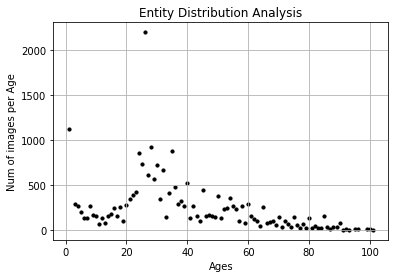

label		Age		Count
0 		 1 		 1123
1 		 3 		 289
2 		 4 		 273
3 		 5 		 196
4 		 6 		 131
5 		 7 		 139
6 		 8 		 263
7 		 9 		 166
8 		 10 		 156
9 		 11 		 65
10 		 12 		 130
11 		 13 		 81
12 		 14 		 157
13 		 15 		 177
14 		 16 		 247
15 		 17 		 158
16 		 18 		 262
17 		 19 		 98
18 		 20 		 284
19 		 21 		 346
20 		 22 		 395
21 		 23 		 426
22 		 24 		 859
23 		 25 		 734
24 		 26 		 2197
25 		 27 		 615
26 		 28 		 918
27 		 29 		 570
28 		 30 		 724
29 		 31 		 350
30 		 32 		 664
31 		 33 		 143
32 		 34 		 409
33 		 35 		 880
34 		 36 		 483
35 		 37 		 293
36 		 38 		 325
37 		 39 		 266
38 		 40 		 526
39 		 41 		 132
40 		 42 		 266
41 		 43 		 157
42 		 44 		 100
43 		 45 		 440
44 		 46 		 153
45 		 47 		 170
46 		 48 		 153
47 		 49 		 148
48 		 50 		 381
49 		 51 		 138
50 		 52 		 232
51 		 53 		 241
52 		 54 		 353
53 		 55 		 268
54 		 56 		 236
55 		 57 		 97
56 		 58 		 271
57 		 59 		 82
58 		 60 		 293
59 		 61 		 161
60 		 62 		 125
61 		 63 		 103
62 		 64 		

In [ ]:
dataset_analysis(train_dataset)

**Dataset Loader**

In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)

In [ ]:
print(f"No. of Batches for AgeDB: {len(train_loader)}")

182

In [ ]:
# t = torch.zeros(NUM_CLASSES-1).float()
# print(type(t))
# print(t.shape)
# print(t)

In [ ]:
# logits = 1000000
# logits = logits + t
# print(logits)

In [ ]:
# torch.sigmoid(logits)

In [ ]:
# t1 = torch.randn(3,3)
# print(t1)
# t2 = torch.sigmoid(t1)
# print(t2)
# t3 = t2 > 0.5
# print(t3)

# torch.sum(t3, 1)

In [ ]:
# _, idx = torch.max(t2, dim=1)
# idx

**Model**

**Initialise Model & Optimizer**

In [ ]:
# import torchvision.models as models
# from torchvision.models.resnet import ResNet, BasicBlock

# pretrained_model = models.resnet34(pretrained=True)
# class MyResNet34(nn.Module):
#     def __init__(self, pretrained_model):
#         super(MyResNet34, self).__init__()
#         self.pretrained = pretrained_model
#         self.pretrained.fc = nn.Linear(model.fc.in_features, 1, bias = False)
#         self.linear_1_bias = nn.Parameter(torch.zeros(NUM_CLASSES-1).float())
        
#     def forward(self, x):
#         # x = self.conv1(x)
#         # x = self.bn1(x)
#         # x = self.relu(x)
#         # x = self.maxpool(x)

#         # x = self.layer1(x)
#         # x = self.layer2(x)
#         # x = self.layer3(x)
#         # x = self.layer4(x)

#         # x = self.avgpool(x)
#         # x = torch.flatten(x, 1)
#         # logits = self.fc(x)
#         logits = self.pretrained(x)
#         logits = logits + self.linear_1_bias
#         probas = torch.sigmoid(logits) 
#         return logits, probas

In [ ]:
# a = MyResNet34(pretrained_model)
# for name,param in a.named_parameters():
#   print(name)

In [ ]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = models.resnet34(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1, bias = False)
model.linear_1_bias = nn.Parameter(torch.zeros(NUM_CLASSES-1).float()) 


params_to_update = model.parameters()
print("Params to learn:")
for name,param in model.named_parameters(): print("\t",name)

model.to(DEVICE)
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)

# coral_resnet34_epoch_25_model_path = '/content/drive/MyDrive/CSE465/Models_and_Logs/Full-UTK-CORAL_ResNet34-Pretrained-Finetuned_100%-EPOCHS-25-withourLRS/Epoch_25_model.pt'
# model.load_state_dict(torch.load(coral_resnet34_epoch_25_model_path))

Params to learn:
	 linear_1_bias
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer2.2.conv1.weight
	 layer2.2.bn1.weight
	 layer2.2.bn1.bias
	 layer2.2.conv2.weight
	 layer2.2.bn2.weight
	 layer2.2.bn2.bias
	 layer2.3.conv1.weight
	 layer2.3.bn1.weight

<All keys matched successfully>

In [ ]:
# model.linear_1_bias.shape

In [ ]:
# model.linear_1_bias

In [ ]:
print(model)

In [ ]:
# x = torch.rand([1,3,224,224])
# logits = model(x)
# logits = logits + model.linear_1_bias[0:5]
# print(logits)
# print('---------------------------------------')
# t = F.logsigmoid(logits)
# print(t)
# print('---------------------------------------')
# y = torch.tensor([1,1,0,0,0])
# t = t*y
# print(t)
# print('---------------------------------------')
# f = F.logsigmoid(logits) - logits
# print(f)
# print('---------------------------------------')
# y_inv = 1-y
# f = f*y_inv
# print(f)
# print('---------------------------------------')
# total = -torch.sum(t+f)
# print(total)
# print('---------------------------------------')
# imp_weight = 0.997
# total = total*imp

In [ ]:
# m = nn.LogSigmoid()
# lol = torch.tensor([-10000000000000.0])
# m(lol)

In [ ]:
#logsigmoid range -infinity to 0
def cost_fn(logits, levels, imp):
    val = (-torch.sum((F.logsigmoid(logits)*levels
                      + (F.logsigmoid(logits) - logits)*(1-levels))*imp,
           dim=1))
    return torch.mean(val)

`torch.max()` `returns` highest elements along the dimension and indexes of highest values, here we are only interested to the indexes of highest elements

In [ ]:
def calculate_correct_preds(probas, targets):
  return torch.sum(torch.max(probas, dim = 1)[1] == targets)

In [ ]:
def compute_acc(total_num_correct_preds, num_examples):
  return format((total_num_correct_preds/num_examples) * 100.0, '.3f')

**Training**

PyTorch Normally add the previously calculated gradient with the current calculated gradient and then updates the weight. But here we don't want it. That's why we made the previously calculted gradient zero while calculating a new one with `optimizer.zero_grad()`

In [ ]:
# x = torch.rand([1,3,224,224])
# logits = model(x)
# logits = logits + model.linear_1_bias[0:5]
# print(logits)
# print('---------------------------------------')
# probas = torch.sigmoid(logits)

In [ ]:
start_time = time.time()

for epoch in tqdm(range(EPOCHS)):
  train_total_num_correct_preds = train_num_examples = 0

  model.train()
  train_mae=0.0
  for batch_idx, (features, targets, levels) in enumerate(tqdm(train_loader)):

    features = features.to(DEVICE)
    targets = targets.to(DEVICE)
    levels = levels.to(DEVICE)

    # FORWARD AND BACK PROP
    logits = model(features)
    logits = logits + model.linear_1_bias
    cost = cost_fn(logits, levels, imp)
    probas = torch.sigmoid(logits)
    predict_levels = probas > 0.5
    predicted_labels = torch.sum(predict_levels, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)

    # _, predicted_labels = torch.max(probas, dim=1)
    optimizer.zero_grad()

    cost.backward()

    # UPDATE MODEL PARAMETERS
    optimizer.step()

    train_total_num_correct_preds += num_correct_preds
    train_num_examples += targets.size(0) 
    train_mae += torch.sum(torch.abs(predicted_labels - targets))
      
  train_mae = train_mae/train_num_examples
  # LOGGING
  print(f'Correct Train Preds: {train_total_num_correct_preds}')
  training_acc = compute_acc(train_total_num_correct_preds, train_num_examples)

  time_elapsed = format((time.time() - start_time)/60, ".3f")
  str1 = f'Epoch: {epoch+1}/{EPOCHS} \n'
  str2 = f'--------------------------------------------------------------------\n'
  str3 = f'Training MAE: {format(train_mae, ".3f")}\n'
  str4 = f'Training_Cost: {format(cost, ".3f")}\n'
  str5 = f'Training_Acc: {training_acc}%\n'
  str6 = f'Time elapsed: {time_elapsed}mins\n'

  str = str1+str2+str3+str4+str5+str6
  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')
  
  model_name = f'Epoch_{epoch+1}_model.pt'
  torch.save(model.state_dict(), os.path.join(PATH, model_name)) # saving the model
  with open(LOGFILE, 'a') as f: f.write(f'---Model Saved---\n')
  print(f'---Model Saved---\n')
    
with open(LOGFILE, 'a') as f: f.write('\n\n############-------Training Completed-------############\n\n')
print("TRAINING COMPLETED")

**Evaluataion**

In [ ]:
def compute_mae_and_mse(model, data_loader, device):
  mae, mse, num_examples, total_num_correct_preds = 0., 0., 0, 0
  for i, (features, targets, levels) in enumerate(data_loader):
          
    targets, features = targets.to(device), features.to(device)
    logits = model(features)
    logits = logits + model.linear_1_bias
    probas = torch.sigmoid(logits)
    predict_levels = probas > 0.5

    predicted_labels = torch.sum(predict_levels, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)
    total_num_correct_preds += num_correct_preds
    num_examples += targets.size(0)

    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

  print(f'total_num_correct_preds: {total_num_correct_preds}')
  acc = compute_acc(total_num_correct_preds, num_examples)
  mae = format(mae.float()/num_examples, '.3f')
  mse = format(torch.sqrt(mse.float()/num_examples), '.3f')      

  return mae, mse, acc

In [ ]:
model.eval()
with torch.set_grad_enabled(False):  # save memory during inference

  train_mae, train_mse, train_acc = compute_mae_and_mse(model, train_loader, device=DEVICE)
  str1 = f'Training MAE: {train_mae}\n'
  str2 = f'Training RMSE: {train_mse}\n'
  str3 = f'Training Acc: {train_acc}%\n'
  str = str1+str2+str3

  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')

str = f'Total Elapsed Time: {format(((time.time() - start_time)/60), ".3f")} mins \n'
print(str)
with open(LOGFILE, 'a') as f: f.write(f'{str}\n')

total_num_correct_preds: 10263
Training MAE: 0.833
Training RMSE: 1.389
Training Acc: 44.224%

Total Elapsed Time: 406.544 mins 



**Saving the Model**

PyTorch: What's the difference between state_dict and parameters()? [link](https://stackoverflow.com/questions/54746829/pytorch-whats-the-difference-between-state-dict-and-parameters)

In [ ]:
# model = model.to(torch.device('cpu'))
# torch.save(model.state_dict(), os.path.join(PATH, 'model.pt'))

In [ ]:
# for i in range(26, 200):
#   print(i)